In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))
from google import colab

colab.drive.mount('/content/gdrive')

import os
import psutil

def print_ram_usage():
    process = psutil.Process(os.getpid())
    ram_usage = round(process.memory_info().rss/float(2**30), 2)
    print('RAM usage: {}GB'.format(ram_usage))
          
print_ram_usage()

if os.path.isfile('gdrive/My Drive/data.zip') and not os.path.isdir('data'):
    print('Unzipping...')
    !unzip -qo gdrive/My\ Drive/data.zip
else:
    print('data directory already ready')
print('done!')

Found GPU at: /device:GPU:0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
RAM usage: 0.65GB
Unzipping...
done!


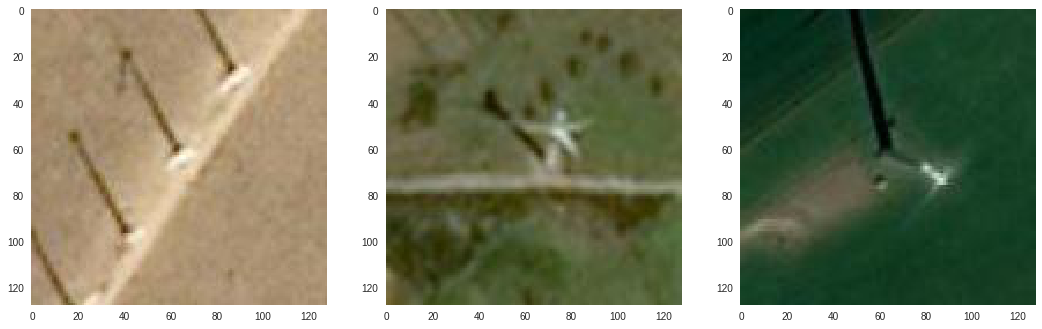

In [0]:
%matplotlib inline

import glob   # permet chercher noms images dans target
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False

images = glob.glob('data_airbus_defi/train/target/*.jpg')

w = 20
h = 20
fig = plt.figure(figsize=(18, 6))
columns = 3
rows = 1

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = mpimg.imread(random.choice(images))
    plt.imshow(img)

In [0]:
import shutil
from tqdm import tqdm
random.seed(117)
fit_ratio = 0.9
val_ratio = 0.1

train_1_files = glob.glob('data_airbus_defi/train/target/*.jpg') #charge img d'éoliennes
random.shuffle(train_1_files)

train_0_files = glob.glob('data_airbus_defi/train/other/*.jpg') #charge img pas éoliennes
random.shuffle(train_0_files)

test_files = glob.glob('data_airbus_defi/test/*.jpg') #a prédire

for p in tqdm(['fit', 'fit/1', 'fit/0', 'val', 'val/0', 'val/1', 'test', 'test/img']):
    if not os.path.exists(p):
        os.mkdir(p)

for file in tqdm(train_1_files[:int(fit_ratio * len(train_1_files))]):
    shutil.copy(file, 'fit/1')
    
for file in tqdm(train_0_files[:int(fit_ratio * len(train_0_files))]):
    shutil.copy(file, 'fit/0')
    
for file in tqdm(train_1_files[-int(val_ratio * len(train_1_files)):]):
    shutil.copy(file, 'val/1')
    
for file in tqdm(train_0_files[-int(val_ratio * len(train_0_files)):]):
    shutil.copy(file, 'val/0')
    
for file in tqdm(test_files):
    shutil.copy(file, 'test/img')

100%|██████████| 17056/17056 [00:02<00:00, 8265.10it/s]


In [0]:
from keras import preprocessing
from keras import callbacks 

fit_gen = preprocessing.image.ImageDataGenerator(
    rotation_range=20,       #20    pour modele 3      #10     # pour modele_IA
    zoom_range=[.9,1.1],     #.8, 1.1                   # [.9,1.1]
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True
)

#prend des images dans fit
fit = fit_gen.flow_from_directory(
    directory='fit',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32, #remontée de gradient sur une moyenen d'images
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_gen = preprocessing.image.ImageDataGenerator()

val = val_gen.flow_from_directory(
    directory='val',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=1,
    class_mode='binary',
    shuffle=True,
    seed=42
)

test_gen = preprocessing.image.ImageDataGenerator()

test = test_gen.flow_from_directory(
    directory='test',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)


Using TensorFlow backend.


Found 61395 images belonging to 2 classes.
Found 6821 images belonging to 2 classes.
Found 17056 images belonging to 1 classes.


In [0]:
from keras import layers 
from keras import losses
from keras import metrics
from keras import models
from keras import optimizers
from keras.models import load_model


def make_cnn():
    input = layers.Input(shape=(128, 128, 3), name='input')
    x = layers.BatchNormalization()(input)
    
    for neurons in [64, 128]:
      x = layers.Conv2D(neurons, kernel_size=(3, 3), padding='same')(x)
      x = layers.normalization.BatchNormalization()(x)
      x = layers.Conv2D(neurons, kernel_size=(3, 3), padding='same')(x)
      x = layers.normalization.BatchNormalization()(x)
      x = layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = layers.Activation('relu')(x)
      x = layers.SpatialDropout2D(0.1)(x)

    for neurons in [256, 512,512]:
      x = layers.Conv2D(neurons, kernel_size=(3, 3), padding='same')(x)
      x = layers.normalization.BatchNormalization()(x)
      x = layers.Conv2D(neurons, kernel_size=(3, 3), padding='same')(x)
      x = layers.normalization.BatchNormalization()(x)
      x = layers.Conv2D(neurons, kernel_size=(3, 3), padding='same')(x)
      x = layers.normalization.BatchNormalization()(x)
      x = layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
      x = layers.Activation('relu')(x)
      x = layers.SpatialDropout2D(0.1)(x)
    
    x = layers.Flatten()(x)
    
    for neurons in [1024, 256]:
      x = layers.Dense(neurons)(x)
      x = layers.normalization.BatchNormalization()(x)
      x = layers.Activation('relu')(x)
      x = layers.Dropout(0.5)(x)

    
    output = layers.Dense(1, activation='sigmoid', name='output')(x)
    
    model = models.Model(inputs=[input], outputs=[output])

    model.compile(
        loss=losses.binary_crossentropy,
        optimizer=optimizers.Adam(),
        metrics=[metrics.binary_accuracy],
    )
    
    return model
  
  
cnn = make_cnn()
#cnn.summary()


Epoch 1/2
1918/1918 [==============================] - 870s 453ms/step - loss: 0.2253 - binary_accuracy: 0.9159 - val_loss: 0.1969 - val_binary_accuracy: 0.9235
Epoch 2/2
1918/1918 [==============================] - 860s 448ms/step - loss: 0.1923 - binary_accuracy: 0.9311 - val_loss: 0.1472 - val_binary_accuracy: 0.9436


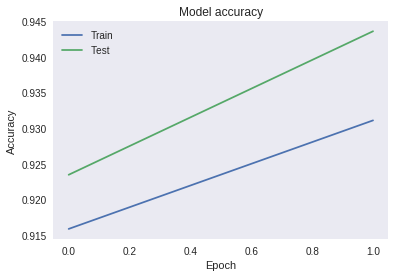

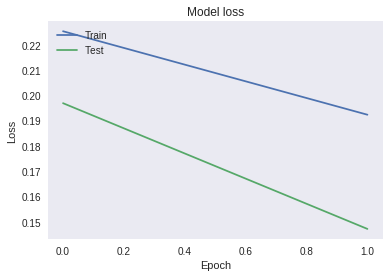

In [0]:
history = cnn.fit_generator(
    generator=fit,
    steps_per_epoch=fit.n // fit.batch_size,
    validation_data=val,
    validation_steps=val.n // val.batch_size,
    epochs=2, 
)

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#cnn.save('gdrive/My Drive/modeldefiIA5.h5')


In [0]:
y_pred = cnn.predict_generator(test,steps=(len(test)), verbose=1)
import pandas as pd

submission = pd.DataFrame({
    'name': test.filenames,
    'prediction': (y_pred[:, 0] > 0.5).astype(int)
})
submission['name'] = submission['name'].apply(lambda x:x.split('/')[1])
print(submission.head())

submission.to_csv('submission_16.csv', index=False, sep=';')

17056/17056 [==============================] - 246s 14ms/step
       name  prediction
0     0.jpg           1
1     1.jpg           0
2    10.jpg           0
3   100.jpg           1
4  1000.jpg           1


In [0]:
cnn = load_model('gdrive/My Drive/modelcheckpoints_test5.h5')  